In [1]:


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor #Since we know that Random Forest can be used for both Classification and Regression,so there are 2 libraries i.e RandomForestRegressor and RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import warnings
warnings.filterwarnings('ignore')
store_sales = pd.read_csv('G:/store_sales.csv')
print(store_sales.head(10))
store_sales.info()

##################################################################Pre-Processing################################################################
input_col=["date","store","item"]
output_col=["sales"]
X_train,Y_train=train_test_split(input_col,output_col,train_size=0.8)
x_incl_cons = sm.add_constant(X_train)
model = sm.OLS(Y_train, x_incl_cons)  #ordinary least square
results = model.fit()  #regresssion results
# results.params
# results.pvalues
mydata=pd.DataFrame({'coef': results.params , 'pvalue': round(results.pvalues,3)})
print(mydata)


store_sales = store_sales.drop(['store','item'], axis=1)#We dropped store and item columns since we only want to predict the future sales of a store.So,considering the sales of various stores as the sales of a single store only . 
store_sales
store_sales['date'] = pd.to_datetime(store_sales['date'],dayfirst=True)#Since the datatype of date column is object(string) ,so converting it into datetime format for better anlaysis of data.
#By default if we use to_datetime() ,it converts into date with format yyyy-mm-dd. If we want date first,then usr dayfirst=True. So,now the format will be yyyy-dd-mm.
store_sales
print("Dataset after converting date into yyyy-dd-mm format")
print(store_sales.head(10))
store_sales['date'] = store_sales['date'].dt.to_period('M')#Aggregation is applied here,since analysing sales on a daily basis is more tedious task,then analysing the sales over a month.Since analysis is to be done month wise. For year wise put 'Y' instead of 'M'.
monthly_sales = store_sales.groupby('date').sum().reset_index()#This is basically used to sum the day-wise sales to convert them to monthly sales.
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
print("Dataset after aggregation: ")
print(monthly_sales.head(10))
plt.figure(figsize=(15,5))#figsize(width,height)
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date in months')
plt.ylabel('Sales in 10^6')
plt.title("Monthly Customer Sales")
plt.show()
print("Data after differncing :")
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()#Here we will find the sales_diff column since the sales column gives us the aggregate sales for all the months before. So, sales_diff represents the sales of a particular month and the sign represents whether it was more or less than the previous month.
print(monthly_sales.head(10))
print("Data after removing NA values : ")
monthly_sales = monthly_sales.dropna()#Basically ,using this because when we subtract the next month sales from previous year sales,then first month will not have any previous month sales to be subtracted,so NaN value will be shown.
print(monthly_sales.head(15))
print("Graph between monthly sales and date on data after differencing: ")
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date in months')
plt.ylabel('Sales in 10^6')
plt.title("Monthly Customer Sales Diff")
plt.show()
dataset = monthly_sales.drop(['date','sales'], axis=1)#It basically contains the sales_diff column
print("Data after removing date and sales: ")
print(dataset.head(10))
for i in range(1,13):
    col_name = 'month_' + str(i)
    dataset[col_name] = dataset['sales_diff'].shift(i)
#Here shifting is bascially done since we want to predict the sales of 13th month taking the sales of previous 12 months as input .
#Here our 1st column is our output feature and then the following 12 columns are our input features.
print("Data after shifting : ")
print(dataset.head(10))
#Drooping the NaN values
dataset = dataset.dropna()#.reset_index(drop=True)
print("Supervised data")
print(dataset.head(10))
#Resetting the indexes 
dataset=dataset.reset_index(drop=True)
print("Supervised data after resetting the indexes")
print(dataset.head(10))
#Performing MinMax Normalization.
scaler = MinMaxScaler()
scaler.fit(dataset)
dataset=scaler.transform(dataset)
dataset=pd.DataFrame(dataset)
print("After Normalization: ")
print(dataset.head(10))
#Splitting the dataset into training and testing data
train_data = dataset[:-12]#Training data includes all rows except last 12 rows 
test_data = dataset[-12:]#Testing data includes last 12 rows .
#Total 46 rows. 34 for training and 12 for testing.
print("Training data: ")
print(train_data.head(10))
print("Testing data: ")
print(test_data)
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)
# scaler = MinMaxScaler()
# scaler1=MinMaxScaler()
# scaler.fit(train_data)#Fit() just calculates the mean and standard deviation.
# train_data = scaler.transform(train_data)#Transform() puts the mean and standard deviation calculated in the formula(in case of Standard Normalization). 
#But here in case of Min Max Scaler,fit() calculates the min and maximum and transform uses those values in transform(). 
#transform() gives output as sparse matrix or array format.
# scaler1.fit(test_data)
# test_data = scaler1.transform(test_data)
# train_data=(train_data-train_data.min())/(train_data.max()-train_data.min())
# test_data=(test_data-test_data.min())/(test_data.max()-test_data.min())
# print("Train data: ")
# print(train_data)
# print("Test data: ")
# print(test_data)
# train_data=pd.DataFrame(train_data)
# test_data=pd.DataFrame(test_data)
# X_train=train_data.iloc[:,1:]
# print("X training data: ")
# print(X_train)
#The iloc() function in python is defined in the Pandas module, which helps us select a specific row or column from the data set.
#If we try to extract columns without using iloc then it might give us error.
X_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0:1]#Upper limit is not included i.e. 0:1 means only the first column.
X_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0:1]
print("Monthly sales df: ")
print(monthly_sales.head(10))
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
print("Sales date : ")
print(sales_dates.head(10))
predict_df = pd.DataFrame(sales_dates)
print("Predict df: ")
print(predict_df)
act_sales = monthly_sales['sales'][-13:].to_list()
print("Act sales df: ")
print(act_sales)
############################################################################################################################################

################################################################Random Forest###############################################################
#Random Forest is an ensemble of decision trees in which the final output value is guided by the average of the outputs of all the decision trees making up the Random Forest model.
#n_estimators->Used to specify the number of decision trees.
#max_depth-> Used to specify the maximum depth of decision tree. Used for pruning the decision tree after the maximum depth is reached.
rf_model=RandomForestRegressor(n_estimators=100,max_depth=20)
rf_model.fit(X_train,y_train)
rf_predict=rf_model.predict(X_test)
print("Predicted data: ")
print(rf_predict)
#Since we normalized the data,so,as to view the actual sales prediction,we use invere_transform.
#The following way gives us the wrong answer: 
# rf_predict=(rf_predict*(rf_predict.max()-rf_predict.min())+rf_predict.min())
# print("After inverse transformation: ")
# print(rf_predict)
#The fit(data) method is used to compute the mean and std dev for a given feature to be used further for scaling. 
#The transform(data) method is used to perform scaling using mean and std dev calculated using the . fit() method.
# scaler=MinMaxScaler()
# scaler.fit(train_data)
rf_predict = rf_predict.reshape(-1,1)
print("After reshaping: ")
print(rf_predict)
rf_pred_test_set = np.concatenate([rf_predict,X_test], axis=1)
print("After concatenation: ")
print(rf_pred_test_set)
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)
print("Final data: ")
print(rf_pred_test_set)
result_list = []
for index in range(0, len(rf_pred_test_set)):
    result_list.append(rf_pred_test_set[index][0] + act_sales[index])
print("Final list is: ")
print(result_list)
rf_pred_series = pd.Series(result_list, name='rf_pred')
print("Rf_pred_series: ")
print(rf_pred_series)
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)
#left_index	    True
#               False	
# Optional. Default False. Whether to use the index from the left DataFrame as join key or not
#right_index	True
#               False	
# Optional. Default False. Whether to use the index from the right DataFrame as join key or not
print("Predicted df: ")
print(predict_df)
# actual_df=actual_df.drop("sales_diff",axis=1)
actual_df=monthly_sales.tail(12).drop("sales_diff",axis=1).reset_index(drop=True)#drop is basically used so,as to drop the original indexes . If we don't keep drop=True,then along with reset indexes,we will get original(previous) indexes as well.
# actaul_df=actual_df
print("Monthly sales (Actual df):")
print(actual_df)
rf_rmse = np.sqrt(mean_squared_error(predict_df['rf_pred'], monthly_sales['sales'][-12:]))
rf_mae = mean_absolute_error(predict_df['rf_pred'], monthly_sales['sales'][-12:])
rf_r2 = r2_score(predict_df['rf_pred'], monthly_sales['sales'][-12:])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['rf_pred'])
plt.title("Customer Sales Forecast using Random Forest")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

KeyboardInterrupt: 

         date  store  item  sales
0  01-01-2013      1     1     13
1  02-01-2013      1     1     11
2  03-01-2013      1     1     14
3  04-01-2013      1     1     13
4  05-01-2013      1     1     10
5  06-01-2013      1     1     12
6  07-01-2013      1     1     10
7  08-01-2013      1     1      9
8  09-01-2013      1     1     12
9  10-01-2013      1     1      9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
Unique stores present in the dataset are: 
[ 1  2  3  4  5  6  7  8  9 10]
Count of each store is: 
1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: store, dtype: int

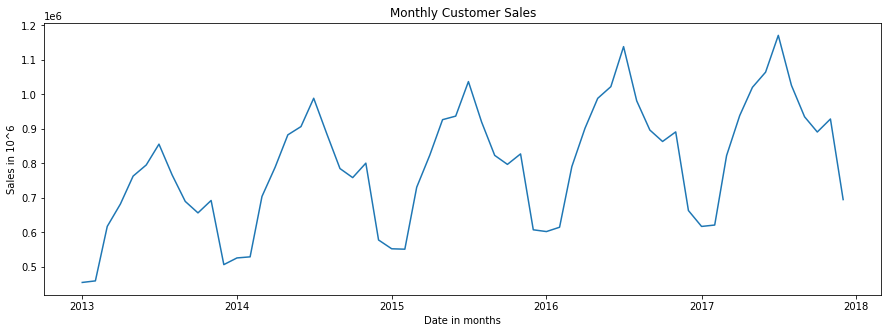

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    60 non-null     datetime64[ns]
 1   sales   60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB
Data after removing date: 
     sales
0   454904
1   459417
2   617382
3   682274
4   763242
5   795597
6   855922
7   766761
8   689907
9   656587
10  692643
11  506607
12  525987
Data after shifting : 
     sales  previous_month_1  previous_month_2  previous_month_3  \
0   454904               NaN               NaN               NaN   
1   459417          454904.0               NaN               NaN   
2   617382          459417.0          454904.0               NaN   
3   682274          617382.0          459417.0          454904.0   
4   763242          682274.0          617382.0          459417.0   
5   795597          763242.0          682274.0       

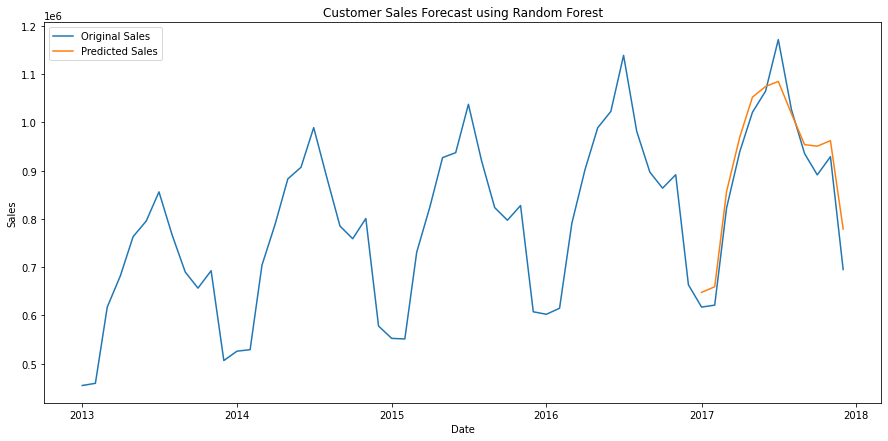

In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor #Since we know that Random Forest can be used for both Classification and Regression,so there are 2 libraries i.e RandomForestRegressor and RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import warnings
warnings.filterwarnings('ignore')
store_sales = pd.read_csv('G:/store_sales.csv')
print(store_sales.head(10))
store_sales.info()
print("Unique stores present in the dataset are: ")
print(store_sales.store.unique())
store_present=store_sales['store']
# print(store.head(10))
sr=pd.Series(store_present)
# print(sr)
print("Count of each store is: ")
print(sr.value_counts())
print("Unique items present in the dataset are: ")
print(store_sales.item.unique())
item_present=store_sales['item']
# print(store.head(10))
sr1=pd.Series(item_present)
# print(sr)
print("Count of each item is: ")
print(sr1.value_counts().sort_index())
#In this dataset first for each store,we have data of each item from 01-01-2013 to 31-12-2017
#store item
# 1     1-> sales from 01-01-2013 to 31-12-2017 ->1826 days (5 years)
# 2     1
# .     .
# 50    1
# 1     2
# 2     2
# and so on... 

##################################################################Pre-Processing################################################################

store_sales = store_sales.drop(['store','item'], axis=1)#We dropped store and item columns since we only want to predict the future sales of a store.So,considering the sales of various stores as the sales of a single store only . 
store_sales
store_sales['date'] = pd.to_datetime(store_sales['date'],dayfirst=True)#Since the datatype of date column is object(string) ,so converting it into datetime format for better anlaysis of data.
#By default if we use to_datetime() ,it converts into date with format yyyy-mm-dd. If we want date first,then usr dayfirst=True. So,now the format will be yyyy-dd-mm.
store_sales
print("Dataset after converting date into yyyy-dd-mm format")
print(store_sales.head(10))
store_sales['date'] = store_sales['date'].dt.to_period('M')#Applying aggregation here,since analysing sales on a daily basis is more tedious task than analysing the sales over a month.Since analysis is to be done month wise. For year wise put 'Y' instead of 'M'.
print("Date in month: ")
print(store_sales["date"])#This will contain th date as yyyy-mm only since dates have been removed.
monthly_sales = store_sales.groupby('date').sum().reset_index()#Now, combining the sales of days having same date which gives us monthly sales.This is basically used to sum the day-wise sales to convert them to monthly sales.
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
print("Dataset after aggregation: ")
print(monthly_sales.head(10))
#Since we are observing data of 5 years which correspond to 60 months(12x5=60)
plt.figure(figsize=(15,5))#figsize(width,height)
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date in months')
plt.ylabel('Sales in 10^6')
plt.title("Monthly Customer Sales")
plt.show()
monthly_sales.info()


dataset = monthly_sales.drop(['date'], axis=1)#It basically contains the sales_diff column
print("Data after removing date: ")
print(dataset.head(13))
for i in range(1,13):
    col_name = 'previous_month_' + str(i)
    dataset[col_name] = dataset['sales'].shift(i)
# #Here shifting is bascially done since we want to predict the sales of 13th month taking the sales of previous 12 months as input .
# #Here our 1st column is our output feature and then the following 12 columns are our input features.
print("Data after shifting : ")
print(dataset.head(13))
# #Dropping the NaN values
#Iniatially we had 60 rows and we have shifted all the values 12 times . So,now 12 rows will be deleted . So, we are left with 48(60-12=48) rows.
dataset = dataset.dropna()
print("Supervised data")
print(dataset.head(10))
#Resetting the indexes 
dataset=dataset.reset_index(drop=True)
print("Supervised data after resetting the indexes")
print(dataset.head(10))
#Final dataset is ready.


#Performing MinMax Normalization.
scaler = MinMaxScaler()
scaler.fit(dataset)
dataset=scaler.transform(dataset)
dataset=pd.DataFrame(dataset)
print("After Normalization: ")
print(dataset.head(10))
#Splitting the dataset into training and testing data
train_data = dataset[:-12]#Training data includes all rows except last 12 rows i.e sales for 4 years.(75%)
test_data = dataset[-12:]#Testing data includes last 12 rows i.e. sale for last year(5th year).(25%)
#Total 48 rows. 36 for training and 12 for testing.
print("Training data: ")
print(train_data.head(10))
print("Testing data: ")
print(test_data)
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)
# scaler = MinMaxScaler()
# scaler1=MinMaxScaler()
# scaler.fit(train_data)#Fit() just calculates the mean,minimum and maximum values.
# train_data = scaler.transform(train_data)#Transform() puts the mean and standard deviation calculated in the formula(in case of Standard Normalization). 
#But here in case of Min Max Scaler,fit() calculates the min and maximum and transform uses those values in transform(). 
#transform() gives output as sparse matrix or array format.
# scaler1.fit(test_data)
# test_data = scaler1.transform(test_data)
# train_data=(train_data-train_data.min())/(train_data.max()-train_data.min())
# test_data=(test_data-test_data.min())/(test_data.max()-test_data.min())
# print("Train data: ")
# print(train_data)
# print("Test data: ")
# print(test_data)
# train_data=pd.DataFrame(train_data)
# test_data=pd.DataFrame(test_data)
# X_train=train_data.iloc[:,1:]
# print("X training data: ")
# print(X_train)
print("Monthly sales df: ")
print(monthly_sales.head(10))
#Taking the dates of months for which we will be predicting in a different dataframe.
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
print("Sales date : ")
print(sales_dates.head(12))
predict_df = pd.DataFrame(sales_dates)
print("Predict df: ")
print(predict_df)#Final dataframe,which now only includes dates and later we will merge the sales column here.

#The iloc() function in python is defined in the Pandas module, which helps us select a specific row or column from the data set.
#If we try to extract columns without using iloc then it gives us error since we can directly access this way in array only.
# X_train, y_train = train_data[:,1:], train_data[:,0:1]#Upper limit is not included i.e. 0:1 means only the first column.
# X_test, y_test = test_data[:,1:], test_data[:,0:1]
X_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0:1]#Upper limit is not included i.e. 0:1 means only the first column.
X_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0:1]
# actual_sales = monthly_sales['sales'][-13:].to_list()
# print("Act sales df: ")
# print(actual_sales)
# actual_sales1=monthly_sales.tail(12)
# print("Actual sales: ")
# print(actual_sales1)
# ############################################################################################################################################

# ################################################################Random Forest###############################################################
# #Random Forest is an ensemble of decision trees in which the final output value is guided by the average of the outputs of all the decision trees making up the Random Forest model.
# #n_estimators->Used to specify the number of decision trees.
# #max_depth-> Used to specify the maximum depth of decision tree. Used for pruning the decision tree after the maximum depth is reached.
rf_model=RandomForestRegressor(n_estimators=100,max_depth=20)
rf_model.fit(X_train,y_train)#Here fit() has 2 arguments i.e. fit(X,y). i.e. training phase where model try to observe patterns ocuur here.
rf_predict=rf_model.predict(X_test)#Here,prediction occurs.It return the answer in array form .
print("Predicted data: ")
print(rf_predict)
# #Since we normalized the data,so,as to view the actual sales prediction,we use invere_transform.
# #The following way gives us the wrong answer: 
# # rf_predict=(rf_predict*(rf_predict.max()-rf_predict.min())+rf_predict.min())
# # print("After inverse transformation: ")
# # print(rf_predict)
# #The fit(data) method is used to compute the mean and std dev for a given feature to be used further for scaling. 
# #The transform(data) method is used to perform scaling using mean and std dev calculated using the . fit() method.
# # scaler=MinMaxScaler()
# # scaler.fit(train_data)
rf_predict = rf_predict.reshape(-1,1)#Reshaping the answer in dataframe form(Column-wise).
print("After reshaping: ")
print(rf_predict)
rf_pred_test_set = np.concatenate([rf_predict,X_test], axis=1)#Changing into form (Output Input) . First value is of output and then input values like we converted 13th and previous 12 month sales by shifting. 
print("After concatenation: ")
print(rf_pred_test_set)
rf_pred_test_set_frame=pd.DataFrame(rf_pred_test_set)
print("Concatenated dataframe first 10 rows: ")
print(rf_pred_test_set_frame.head(10))
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)
print("Final data: ")
print(rf_pred_test_set)
final_dataframe=pd.DataFrame(rf_pred_test_set)
print("Final dataframe first 10 rows: ")
print(final_dataframe.head(10))
result_list = []
for index in range(0, len(rf_pred_test_set)):
    result_list.append(rf_pred_test_set[index][0])
print("Final list is: ")
print(result_list)
rf_pred_series = pd.Series(result_list, name='rf_pred')
print("Rf_pred_series: ")
print(rf_pred_series)
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)
# #left_index	    True
# #               False	
# # Optional. Default False. Whether to use the index from the left DataFrame as join key or not
# #right_index	True
# #               False	
# # Optional. Default False. Whether to use the index from the right DataFrame as join key or not
print("Predicted df: ")
print(predict_df)
# # actual_df=actual_df.drop("sales_diff",axis=1)
actual_df=monthly_sales.tail(12).reset_index(drop=True)#.drop("sales_diff",axis=1).reset_index(drop=True)#drop is basically used so,as to drop the original indexes . If we don't keep drop=True,then along with reset indexes,we will get original(previous) indexes as well.
# # actaul_df=actual_df
print("Monthly sales (Actual df):")
print(actual_df)
rf_rmse = np.sqrt(mean_squared_error(predict_df['rf_pred'], monthly_sales['sales'][-12:]))
rf_mae = mean_absolute_error(predict_df['rf_pred'], monthly_sales['sales'][-12:])
rf_r2 = r2_score(predict_df['rf_pred'], monthly_sales['sales'][-12:])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['rf_pred'])
plt.title("Customer Sales Forecast using Random Forest")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()